In [2]:
# 📦 Import required libraries
from fastai.vision.all import *
import matplotlib.pyplot as plt

# 📥 A.1 Download the data (Assuming already downloaded & extracted into 'data/')
path = Path('dataset/garbage_classification')  # Change this to your actual folder

# 📂 A.1.1 Inspect the folder layout
path.ls()


(#12) [Path('dataset/garbage_classification/biological'),Path('dataset/garbage_classification/trash'),Path('dataset/garbage_classification/metal'),Path('dataset/garbage_classification/green-glass'),Path('dataset/garbage_classification/cardboard'),Path('dataset/garbage_classification/clothes'),Path('dataset/garbage_classification/paper'),Path('dataset/garbage_classification/battery'),Path('dataset/garbage_classification/brown-glass'),Path('dataset/garbage_classification/white-glass'),Path('dataset/garbage_classification/plastic'),Path('dataset/garbage_classification/shoes')]

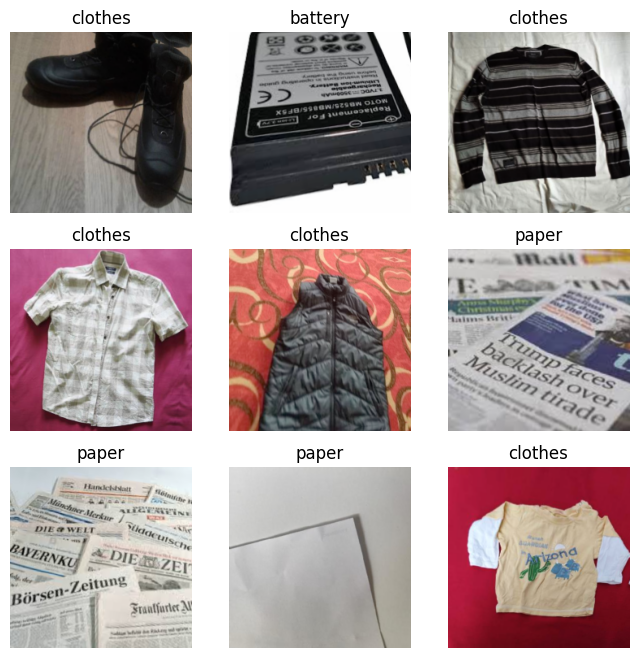

In [4]:
# A.2. Create the DataBlock and dataloaders
garbage_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),             # A.2.1 Define blocks
    get_items=get_image_files,                      # A.2.2 How to get images
    get_y=parent_label,                             # A.2.3 Get label from folder name
    splitter=RandomSplitter(valid_pct=0.2, seed=42),# Split train/valid
    item_tfms=Resize(460),                          # A Word on Presizing (larger resize first)
    batch_tfms=aug_transforms(size=224)             # A.2.4 Batch transforms
)

dls = garbage_block.dataloaders(path, bs=64)

# 👁️ A.3.1 Show batch
dls.show_batch(max_n=9, figsize=(8, 8))

In [5]:
# ✅ A.3.2 Check labels
print(dls.vocab)
print(f"Number of classes: {len(dls.vocab)}")


['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Number of classes: 12


In [7]:
# 🧠 A.4.1 Train a simple model (benchmark)
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(3)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/alpdemiral/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth

00%|██████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 27.5MB/s]

epoch,train_loss,valid_loss,accuracy,time
0,0.589879,0.264426,0.915888,00:29


epoch,train_loss,valid_loss,accuracy,time
0,0.291561,0.193269,0.944892,00:36
1,0.201514,0.128879,0.959716,00:36
2,0.096333,0.116560,0.964873,00:36


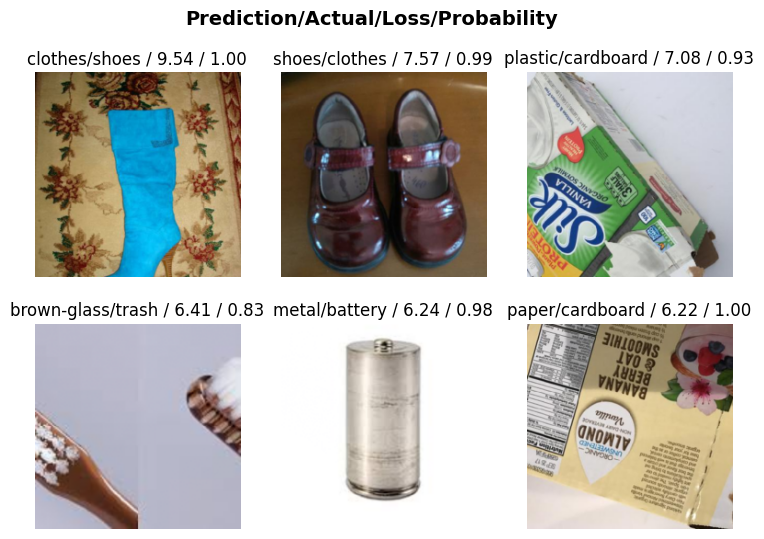

In [8]:
# 🔍 A.4.2 Interpret model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(6, nrows=2)

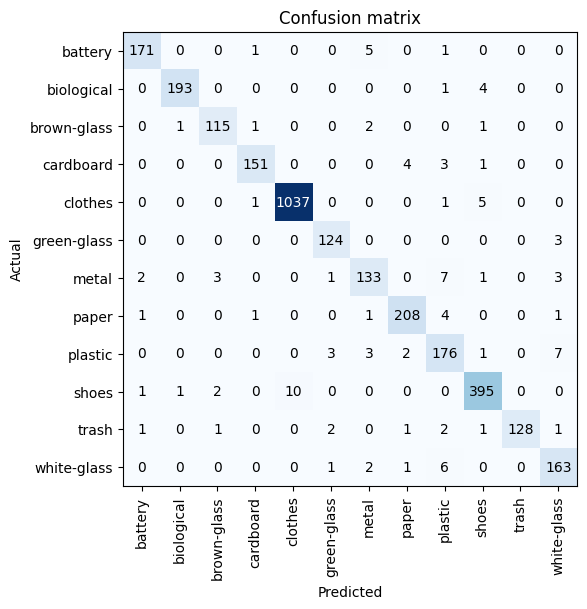

In [9]:
# 🔀 A.4.3 Confusion Matrix
interp.plot_confusion_matrix(figsize=(6, 6), dpi=100)


SuggestedLRs(valley=1.2022644114040304e-05)

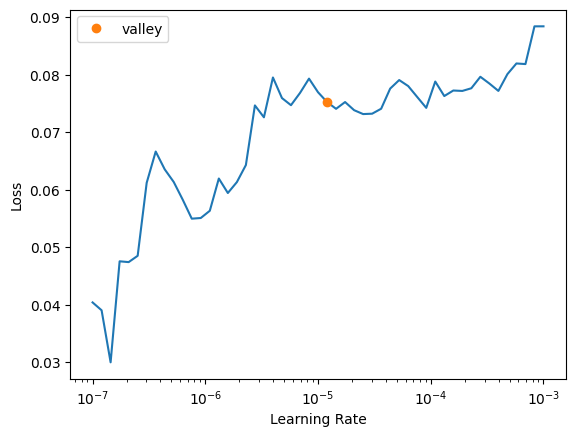

In [10]:
# 🔬 B.1 Learning Rate Finder
learn.lr_find()


In [11]:
# 🔎 Choose best learning rate
# Let's pick value just before loss shoots up
learn.fine_tune(5, base_lr=1e-5)


epoch,train_loss,valid_loss,accuracy,time
0,0.084472,0.110641,0.965517,00:30


epoch,train_loss,valid_loss,accuracy,time
0,0.093390,0.113969,0.965840,00:36
1,0.084971,0.112919,0.965195,00:36
2,0.088276,0.112845,0.965195,00:37
3,0.083720,0.110192,0.967451,00:37
4,0.092738,0.109527,0.968095,00:38


In [12]:
# 💪 B.3 Transfer Learning
# Already used resnet18; the last layer is replaced by fastai
learn.model[1]


Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=12, bias=False)
)

In [14]:
# ❄️ Freeze + Train → 🔓 Unfreeze + Train (B.3)
learn.freeze()
learn.fit_one_cycle(3, 1e-3)
learn.unfreeze()
learn.fit_one_cycle(3, lr_max=slice(1e-5, 1e-3))  # B.4 Discriminative LRs


epoch,train_loss,valid_loss,accuracy,time
0,0.103093,0.114526,0.963906,00:31
1,0.097159,0.115107,0.963584,00:30
2,0.066947,0.111168,0.965840,00:31


epoch,train_loss,valid_loss,accuracy,time
0,0.127095,0.168989,0.953916,00:38
1,0.096042,0.137717,0.960039,00:38
2,0.054578,0.109719,0.965517,00:38


In [15]:
# ⚖️ B.6 Mixed Precision & Model Capacity
# Use resnet34 or resnet50 and to_fp16
learn = vision_learner(dls, resnet34, metrics=accuracy).to_fp16()
learn.fine_tune(4)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/alpdemiral/.cache/torch/hub/checkpoints/resnet34-b627a593.pth

/home/alpdemiral/miniconda3/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/alpdemiral/miniconda3/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,0.541151,0.228337,0.926523,00:31


epoch,train_loss,valid_loss,accuracy,time
0,0.262710,0.165389,0.947148,00:40
1,0.187993,0.125595,0.962295,00:40
2,0.101901,0.098687,0.970674,00:39
3,0.052283,0.094370,0.972285,00:40


In [ ]:
learn.export("models/garbage_classifier.pkl")